In [1]:
cd ..

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import load_cleaned_russian_text_data, evaluate_model, get_3d_quartile_words_count, SEED

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


## Train model

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers, losses

In [5]:
MAX_FEATURES = 10000
MAX_SEQUENCE_LENGTH = get_3d_quartile_words_count(X_train.flatten())

vectorize_layer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)
vectorize_layer.adapt(X_train)

In [6]:
model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    vectorize_layer,
    layers.Embedding(
        input_dim = len(vectorize_layer.get_vocabulary()),
        output_dim = 16
    ),
    layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [7]:
epochs = 10
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=2**9,
    validation_split=0.2, # сколько от тестовой выборки отрезать под валидационную
)

Epoch 1/10
19/19 [==============================] - 5s 131ms/step - loss: 0.6891 - binary_accuracy: 0.6021 - recall: 0.3815 - precision: 0.4218 - val_loss: 0.6728 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 0.6682 - binary_accuracy: 0.6616 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6509 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 0s 18ms/step - loss: 0.6453 - binary_accuracy: 0.6652 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6300 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 0s 15ms/step - loss: 0.6280 - binary_accuracy: 0.6584 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6097 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000

# Model evaluation

Accuracy: 86.75%
Recall: 68.87%
Precision: 88.54%
F1-score: 77.48% 



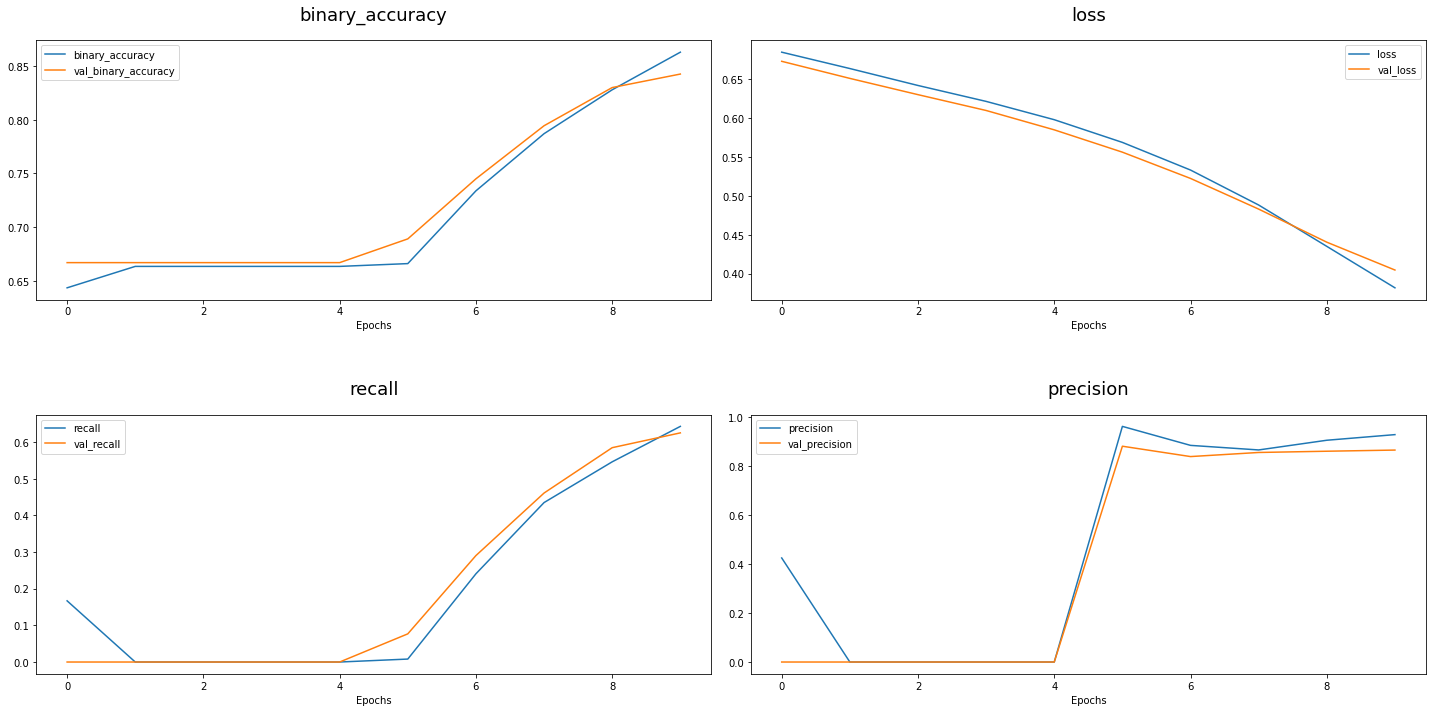

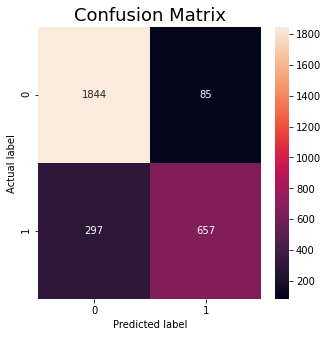

In [8]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)